In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datasets import load_dataset
from seqeval.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

/Users/devambani/Projects/nlp/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

In [3]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

In [4]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 23148.21 examples/s]


In [5]:
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    attention_mask = [torch.tensor(x["attention_mask"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

train_loader = DataLoader(tokenized_datasets["train"], batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=64, collate_fn=collate_fn)

In [6]:
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    attention_mask = [torch.tensor(x["attention_mask"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

train_loader = DataLoader(tokenized_datasets["train"], batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=64, collate_fn=collate_fn)

In [7]:
class DistilBERTForNER(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, dropout_rate=0.3):
        super(DistilBERTForNER, self).__init__()
        self.distilbert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Only the last hidden state is used
        sequence_output = self.dropout(hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

Epoch 1 - Training: 100%|██████████| 220/220 [05:51<00:00,  1.60s/it]


Epoch 1 Training Loss: 0.3944


Epoch 1 - Validation: 100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


Epoch 1 Validation Loss: 0.1430


Epoch 2 - Training: 100%|██████████| 220/220 [05:12<00:00,  1.42s/it]


Epoch 2 Training Loss: 0.1227


Epoch 2 - Validation: 100%|██████████| 51/51 [00:15<00:00,  3.20it/s]


Epoch 2 Validation Loss: 0.0845


Epoch 3 - Training: 100%|██████████| 220/220 [05:24<00:00,  1.47s/it]


Epoch 3 Training Loss: 0.0603


Epoch 3 - Validation: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Epoch 3 Validation Loss: 0.0796


Epoch 4 - Training: 100%|██████████| 220/220 [06:08<00:00,  1.67s/it]


Epoch 4 Training Loss: 0.0380


Epoch 4 - Validation: 100%|██████████| 51/51 [00:21<00:00,  2.36it/s]


Epoch 4 Validation Loss: 0.0783


Epoch 5 - Training: 100%|██████████| 220/220 [05:18<00:00,  1.45s/it]


Epoch 5 Training Loss: 0.0262


Epoch 5 - Validation: 100%|██████████| 51/51 [00:16<00:00,  3.06it/s]


Epoch 5 Validation Loss: 0.0918


Epoch 6 - Training: 100%|██████████| 220/220 [05:47<00:00,  1.58s/it]


Epoch 6 Training Loss: 0.0188


Epoch 6 - Validation: 100%|██████████| 51/51 [00:17<00:00,  2.84it/s]


Epoch 6 Validation Loss: 0.0862


Epoch 7 - Training: 100%|██████████| 220/220 [05:38<00:00,  1.54s/it]


Epoch 7 Training Loss: 0.0167


Epoch 7 - Validation: 100%|██████████| 51/51 [00:16<00:00,  3.09it/s]


Epoch 7 Validation Loss: 0.0925


Epoch 8 - Training: 100%|██████████| 220/220 [05:16<00:00,  1.44s/it]


Epoch 8 Training Loss: 0.0113


Epoch 8 - Validation: 100%|██████████| 51/51 [00:15<00:00,  3.24it/s]


Epoch 8 Validation Loss: 0.0875


Epoch 9 - Training: 100%|██████████| 220/220 [04:48<00:00,  1.31s/it]


Epoch 9 Training Loss: 0.0124


Epoch 9 - Validation: 100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


Epoch 9 Validation Loss: 0.0843


Epoch 10 - Training: 100%|██████████| 220/220 [04:53<00:00,  1.33s/it]


Epoch 10 Training Loss: 0.0084


Epoch 10 - Validation: 100%|██████████| 51/51 [00:15<00:00,  3.38it/s]


Epoch 10 Validation Loss: 0.0902


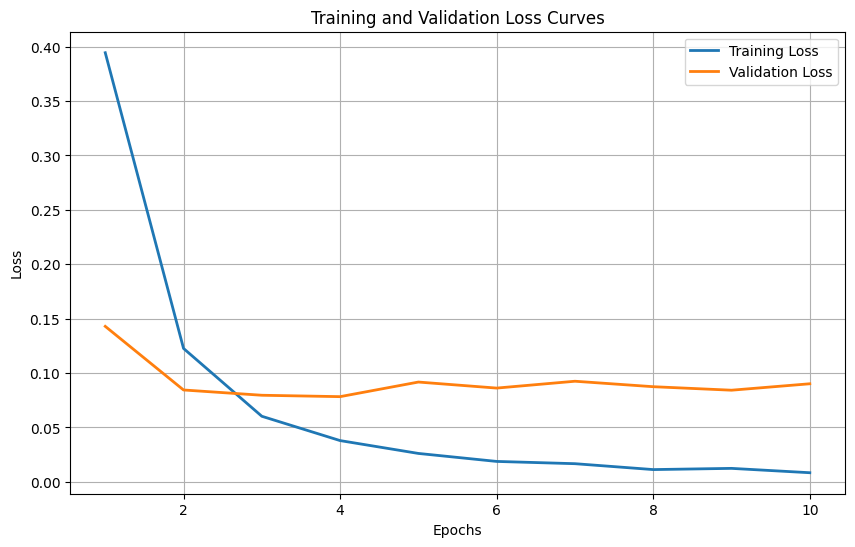

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTForNER(pretrained_model_name="distilbert-base-cased", num_labels=num_labels, dropout_rate=0.3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize lists to track losses
train_losses = []
val_losses = []

# Training Loop
epochs = 10
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Compute average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            total_val_loss += loss.item()

    # Compute average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

# Plot the loss curves after training
def plot_loss_curves(train_losses, val_losses, save_path=None):
    """
    Plot training and validation loss curves.

    Args:
        train_losses (list): List of training loss values for each epoch.
        val_losses (list): List of validation loss values for each epoch.
        save_path (str): If provided, save the plot to this path.
    """
    epochs = range(1, len(train_losses) + 1)  # Epoch numbers

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid()

    if save_path:
        plt.savefig(save_path)  # Save the plot to the specified path
    plt.show()


# Call the function to plot
plot_loss_curves(train_losses, val_losses, save_path="training_validation_loss.png")

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DistilBERTForNER(pretrained_model_name="distilbert-base-cased", num_labels=num_labels, dropout_rate=0.3).to(device)
# optimizer = AdamW(model.parameters(), lr=5e-5)

# # Training Loop
# epochs = 5
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
#         optimizer.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs["loss"]
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")

Epoch 1: 100%|██████████| 220/220 [05:28<00:00,  1.49s/it]


Epoch 1 Loss: 0.38091546448624947


Epoch 2: 100%|██████████| 220/220 [05:01<00:00,  1.37s/it]

Epoch 2 Loss: 0.11948376615764573


In [10]:
# Define the DataLoader for the test dataset
test_loader = DataLoader(
    tokenized_datasets["test"], batch_size=64, collate_fn=collate_fn  # Adjust batch size if needed
)

# Evaluate on test data
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=-1)

        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            # Exclude padding tokens
            predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
            true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

# Compute the classification report
from seqeval.metrics import classification_report

print("Test Data Evaluation Metrics:")
print(classification_report(true_labels, predictions, digits=4))

Evaluating on Test Data: 100%|██████████| 54/54 [00:21<00:00,  2.55it/s]


Test Data Evaluation Metrics:
              precision    recall  f1-score   support

         LOC     0.9208    0.9063    0.9135      3000
        MISC     0.6860    0.7488    0.7160      1266
         ORG     0.8573    0.9083    0.8821      3524
         PER     0.8836    0.9190    0.9010      2989

   micro avg     0.8602    0.8920    0.8758     10779
   macro avg     0.8369    0.8706    0.8531     10779
weighted avg     0.8621    0.8920    0.8765     10779



In [15]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=-1)

        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
            true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

# Compute classification report
print(classification_report(true_labels, predictions))

Evaluating: 100%|██████████| 51/51 [00:18<00:00,  2.74it/s]


              precision    recall  f1-score   support

         LOC       0.96      0.90      0.93      3635
        MISC       0.83      0.77      0.80      1480
         ORG       0.83      0.89      0.86      2702
         PER       0.95      0.92      0.94      3329

   micro avg       0.90      0.89      0.90     11146
   macro avg       0.89      0.87      0.88     11146
weighted avg       0.91      0.89      0.90     11146



In [18]:
def predict_ner_from_dataset(dataset, index, model, tokenizer, label_list):
    """
    Predict NER tags for a sentence from the dataset using the trained model.

    Args:
        dataset (Dataset): The tokenized dataset to pick an example from.
        index (int): Index of the sentence to use from the dataset.
        model (torch.nn.Module): Trained NER model.
        tokenizer (AutoTokenizer): Tokenizer used for tokenizing the sentence.
        label_list (list): List of label names corresponding to NER tags.

    Returns:
        dict: Contains original sentence, tokenized input, and predicted labels.
    """
    # Extract the sentence and true labels from the dataset
    sentence_tokens = dataset["tokens"][index]
    true_labels = dataset["ner_tags"][index]

    # Tokenize the input sentence
    tokenized_inputs = tokenizer(sentence_tokens, truncation=True, return_tensors="pt", is_split_into_words=True)
    input_ids = tokenized_inputs["input_ids"].to(device)
    attention_mask = tokenized_inputs["attention_mask"].to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

    # Decode tokens and predicted labels
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())
    predicted_labels = [label_list[pred] for pred in predictions]
    true_labels_decoded = [label_list[label] for label in true_labels]

    return {
        "sentence": " ".join(sentence_tokens),
        "tokens": tokens,
        "predicted_labels": predicted_labels,
        "true_labels": true_labels_decoded,
    }


# Select an example from the validation dataset (use tokenized_datasets["validation"])
example_index = 0  # Replace with any valid index
result = predict_ner_from_dataset(dataset["validation"], example_index, model, tokenizer, label_list)

# Display the results
print("Original Sentence:")
print(result["sentence"])
print("\nTokenized Input:")
print(result["tokens"])
print("\nPredicted Labels:")
print(result["predicted_labels"])
print("\nTrue Labels:")
print(result["true_labels"])

Original Sentence:
CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .

Tokenized Input:
['[CLS]', 'CR', '##IC', '##KE', '##T', '-', 'L', '##EI', '##CE', '##ST', '##ER', '##S', '##H', '##IR', '##E', 'T', '##A', '##KE', 'O', '##VE', '##R', 'AT', 'TO', '##P', 'A', '##FT', '##ER', 'IN', '##NI', '##NG', '##S', 'VI', '##CT', '##OR', '##Y', '.', '[SEP]']

Predicted Labels:
['I-ORG', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O', 'O', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'B-PER', 'I-MISC', 'I-MISC', 'I-MISC', 'O', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O']

True Labels:
['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
